# Preliminary Fourier Analysis of Passive SONAR Array Data

This code is meant to be read through in a linear fashion. Otherwise, variable reassignments and the logic will not make sense. 

In [2]:
# PREMISE 
# There is an acoustic pinger located some distance away from an autonomous submarine in some body of water. 
# The pinger pings at certain intervals, emitting a wave with x frequency and y amplitude. 
# The baseline amplitude is measured at a distance of z away from the pinger under ideal conditions. 
# The submarine has 4 hydrophones which are listening for pulses. They are a known distance away from each other in a certain configuration. 
# The data to the hydrophones must be used to figure out the autonomous submarine's position in relation to the acoustic pinger. 

# NOTES 
# Note that the data has been passed through first order high pass filter with a corner frequency of 50 Hz, 
# followed by an 8th order low pass filter with corner frequency of 50 kHz.

# FILES 
# ./SampleData1/1.csv is the primary file being used here. It corresponds to the first test of this sytem. It has 5 columns, the first four being 
# the discrete signals received by the hydrophone, and the last one being the index. 2.csv, 3.csv, and 4.csv, all located in sampleData1,
# are all also usable. 

# This file will use the csv data located in the file and conduct an analysis on it. 
# The csv file has 4 columns, which include sine wave data. 
# This data is from the following forum post: https://robonationforum.vbulletin.net/forum/robosub/-2020-robosub/3113-sample-hydrophone-data

# SPECIFICATIONS 
# Pinger Being Used: 
# Sampling Rate for Each Hydrophone: 250000 samples per second. 
# Hydrophones are located on the corners of a 15 mm square. Each side of the square is 15mm, so the positions of the hydrophones are as follows. 
# Hydrophone 1: (7.5 mm, 7.5 mm)
# Hydrophone 2: (-7.5 mm, 7.5 mm)
# Hydrophone 3: (-7.5 mm, -7.5 mm)
# Hydrophone 4: (7.5 mm, -7.5 mm)

## Imports and Files

In [3]:
# Classic Imports 
import pandas as pd
import numpy as np

import math
import time

# Accessing File Imports 
from pathlib import Path

# Plotting Imports 
from matplotlib import pyplot as plt

# Library FFT Imports 
from scipy.fft import fft, fftfreq

# Custom Imports
from wave_generator import create_wave

# CSV Being Analyzed 
dataFile = "./sampleData1/1.csv"

# All Relevant Variables 
csv_sampling_frequency = 250000
csv_num_data_points = 16384

## Cleaning CSV File Using Pandas, Numpy

In [4]:
# The following code opens and looks at the first couple of rows of data from the csv. 

# The load_hydrophone_data function opens a CSV file. 
def load_hydrophone_data():
    return pd.read_csv(Path(dataFile), header = None)

hydrophoneData = load_hydrophone_data()
hydrophoneData.head()                                  # Gives first couple of lines of the csv

,0,1,2,3,4
0,-0.333863,-0.130310,0.581665,0.252381,0
1,-0.571900,-0.387574,0.679322,0.166931,1
2,-0.588379,-0.499878,0.295410,-0.138245,2
3,-0.431824,-0.582886,-0.359497,-0.449829,3
4,-0.288696,-0.663147,-0.852357,-0.590210,4


In [5]:
# Cleaning up the CSV File 
# This section of code simply adds a "time" column, and labels the columns correctly. 

def addTime(x): 
    return x / csv_sampling_frequency

hydrophoneData.columns = ['hydrophone1', 'hydrophone2', 'hydrophone3', 'hydrophone4', 'time'] 
hydrophoneData["time"] = hydrophoneData["time"].apply(addTime)

hydrophoneData

,hydrophone1,hydrophone2,hydrophone3,hydrophone4,time
0,-0.333863,-0.130310,0.581665,0.252381,0.000000
1,-0.571900,-0.387574,0.679322,0.166931,0.000004
2,-0.588379,-0.499878,0.295410,-0.138245,0.000008
3,-0.431824,-0.582886,-0.359497,-0.449829,0.000012
4,-0.288696,-0.663147,-0.852357,-0.590210,0.000016
...,...,...,...,...,...
1048571,-0.208435,-0.254822,-0.172730,-0.195923,4.194284
1048572,-0.258484,-0.287476,-0.170593,-0.169678,4.194288
1048573,-0.295105,-0.243530,-0.176392,-0.206909,4.194292
1048574,-0.296631,-0.167847,-0.181885,-0.280152,4.194296


<AxesSubplot: xlabel='time'>

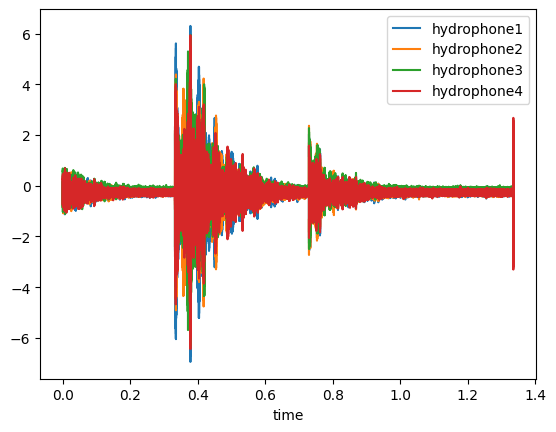

In [14]:
# Takes the first x:y samples from each of the hydrophones and stores them in sampleHydrophoneData for analysis. 
# These x:y samples are only used to see a visual plot of how the waves look like. It is not referenced later. 

# sampleHydrophoneData = hydrophoneData.iloc[333618:333625, :]
sample1HydrophoneData = hydrophoneData.iloc[333618:334000, :]
sample1HydrophoneData = pd.DataFrame(sample1HydrophoneData)

sample1HydrophoneData.plot(x = 'time')

In [7]:
sample1HydrophoneData

,hydrophone1,hydrophone2,hydrophone3,hydrophone4,time
333618,-0.504761,-0.333252,-0.642090,-0.379029,1.334472
333619,-0.761109,-0.608216,-0.022888,0.379639,1.334476
333620,-0.571900,-0.751648,0.746155,0.867921,1.334480
333621,0.145264,-0.386963,0.980836,0.650940,1.334484
333622,0.872498,0.336304,0.408325,-0.223999,1.334488
...,...,...,...,...,...
333995,1.522523,1.876527,-0.420227,-2.102357,1.335980
333996,-0.219116,0.791016,-1.990968,-2.891237,1.335984
333997,-2.044374,-0.888673,-2.539370,-2.199404,1.335988
333998,-2.898257,-2.284853,-1.736451,-0.523377,1.335992


## Fourier Analysis Begins Here

In [8]:
# This boolean value determines whether to use the custom data created in the module below, 
# or to use the csv data referenced in modules above. 
use_custom_data = False

### Creating Custom Sample Data

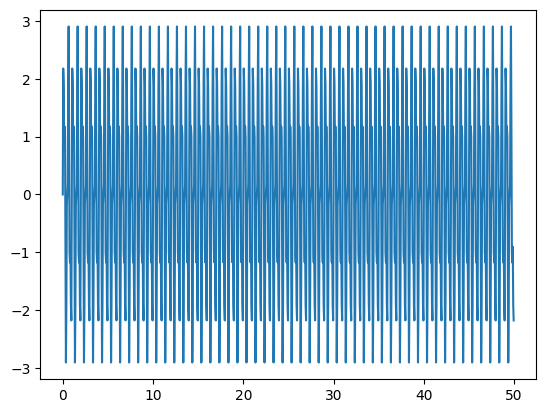

In [9]:
# Creating Sample Data to Analyze 

# This function is located in the file wave_generator.py
# First argument is the number of data points to generate. 
# Second argument is the sampling rate (data points per second). 
# Third argument is a 2D array where each inner array has 3 arguments, 
# frequency, magnitude, and starting time (in seconds). 

custom_num_data_points = 1000
custom_sampling_freq = 20

from wave_generator import create_wave

temp = create_wave(custom_num_data_points, custom_sampling_freq, [[5, 1, 0], [2, 2, 0]])

custom_time_array = temp[0]
custom_sample = temp[1]

plt.plot(custom_time_array, custom_sample)

### Setting up CSV Data for Fourier Analysis

In [10]:
csv_sample = hydrophoneData
csv_num_data_points = 1000
csv_sampling_freq = 250000

### Choosing Whether to Use Custom Data or CSV Data

In [11]:
if (use_custom_data):
    starting_data_point = 0                     # The starting data point 
    N = custom_num_data_points                  # Number of data points to be analyzed
    sampling_frequency = custom_sampling_freq   # Sampling Frequency

    sample = custom_sample[starting_data_point:(starting_data_point + N)]  # Actual Data (shortened)

else:
    starting_data_point = 000000                     # The starting data point 
    N = csv_num_data_points                     # Number of data points to be analyzed
    sampling_frequency = csv_sampling_freq      # Sampling Frequency

    sample = np.array(csv_sample[starting_data_point:(starting_data_point + N)]["hydrophone1"])     # Actual Data (shortened)

Using the scipy library, 1000 were analyzed in 0.00013518333435058594 seconds.


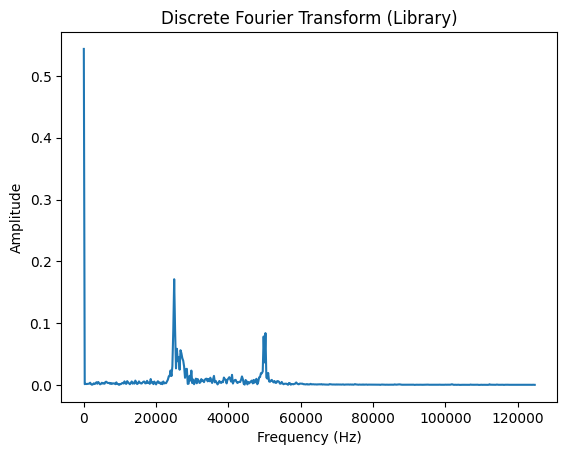

In [12]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(sample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

Using the manual function, 1000 were analyzed in 0.5273950099945068 seconds.


Text(0.5, 1.0, 'Discrete Fourier Transform (Manual)')

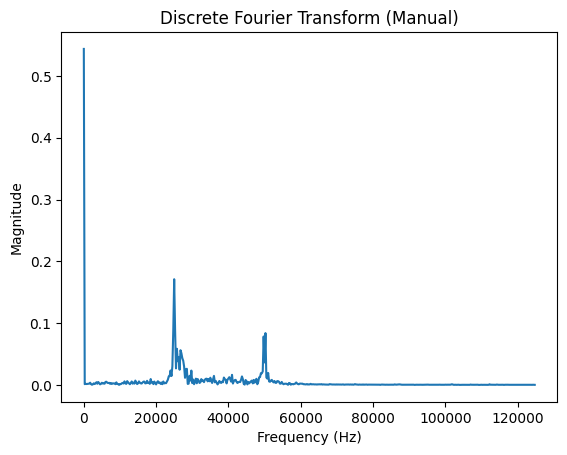

In [13]:
# DISCRETE FOURIER TRANSFORM (FROM SCRATCH)

import math
from matplotlib import pyplot as plt

# N = 200                                        # Number of Samples 
# sampling_freq = 250000                          # Sampling Frequency 
# freq_resolution = sampling_freq / N             # Frequency Resolution 
# data = shortenedHydrophoneData                  # Data in Array 

# CUSTOM DATA (FROM MODULE ABOVE)

# CSV DATA (LOCAL TO THIS MODULE, CAN BE ENABLED TO ANALYZE DIFFERENT DATA THAN SET UP TWO MODULES ABOVE)
# -------------------------------------------------------------------------------------
# N = 1000
# sampling_frequency = 250000
# frequency_resolution = sampling_frequency / N
# sample = np.array(csv_sample[334000:(334000 + N)]["hydrophone1"])
# -------------------------------------------------------------------------------------


# Example Data from Video (https://www.youtube.com/watch?v=mkGsMWi_j4Q)
# -------------------------------------------------------------------------------------
# N = 16                                                        # Number of Samples 
# sampling_freq = 8                                             # Sampling Frequency 
# freq_resolution = sampling_freq / N                           # Frequency Resolution 
# data = [0, 0.707, 1, 0.707, 0, -0.707, -1, -0.707,            # Data in Array 
#         0, 0.707, 1, 0.707, 0, -0.707, -1, -0.707]            
# -------------------------------------------------------------------------------------

start = time.time()

# Creates a list of frequency bins 
bin_width = sampling_frequency / N
frequency_bins = []

counter = 0
for i in range(N):
    frequency_bins.append(counter)
    counter = counter + bin_width

# Main Discrete Fourier Transform 
final_data = []

for i in range(N):
    real = 0
    complex = 0

    for j in range(N):
        real = real + sample[j] * math.cos(-2 * math.pi * i * j / N)
        complex = complex + sample[j] * math.sin(-2 * math.pi * i * j / N)
    
    temporary = [real, complex]
    final_data.append(temporary)

# Finds magnitude for each frequency bin and places into a new array
magnitude_array = []

for x in final_data: 
    magnitude = math.sqrt((x[0])**2 + (x[1])**2)
    magnitude_array.append(magnitude)

# Deals with the Nyquist Limit By Doubling the First Half of all Entries in 
# frequency_bins and magnitude_array. 

magnitude_array_nyquist = []
for x in range(len(magnitude_array) // 2):
    magnitude_array_nyquist.append((magnitude_array[x] * 2) / N)

frequency_bins_nyquist = []
for x in range(len(frequency_bins) // 2):
    frequency_bins_nyquist.append(frequency_bins[x])

end = time.time()
print("Using the manual function, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

# Plots the Magnitude for Each Frequency Bin 
plt.plot(frequency_bins_nyquist, magnitude_array_nyquist)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Discrete Fourier Transform (Manual)")